In [2]:
import sys
sys.path.append('..')
from src.evo_eq_model import *

In [3]:
import random
import numpy.random as rnd
import networkx as nx
from anytree import Node
from tqdm import tqdm
import numpy as np
import os
import sys
# from jupyter_server import serverapp as app; 
# import ipykernel, requests;
if(sys.version_info[1]<= 7):
    import pickle5 as pickle
else:
    import pickle

import pandas as pd
import scipy.interpolate as spi
import scipy.optimize as so

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl

from matplotlib.ticker import FuncFormatter

fmt = lambda x, pos: '{:.1f}'.format(x)
from numba import jit

#matplotlib.use('TkAgg')
from matplotlib.lines import Line2D
plt.rc('mathtext', default='regular')
plt.rc('lines', linewidth=3.0)
plt.rcParams['xtick.labelsize']=30
plt.rcParams['ytick.labelsize']=30
plt.rcParams['axes.labelsize']=35
plt.rcParams['legend.fontsize']= 35
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['image.cmap']='coolwarm'
plt.rcParams['axes.titlesize'] = 40
plt.rcParams['figure.titlesize'] = 40
#set legend titlesize to 40
plt.rcParams['legend.title_fontsize'] = 40

In [4]:

home = os.path.expanduser("~")
project_path =  os.path.relpath("..")
if project_path not in sys.path:
    sys.path.append(project_path)

sys.path.insert(1, project_path)
output_folder= project_path+'/outputs/'

In [5]:
def model(X, t, R0, kappa):
    x = X[0]
    y = X[1]
    z = X[2]
    dxdt = - R0/(1+kappa * y) *x * y
    dydt =  R0/(1+kappa* y) * x * y - y
    dzdt = y
    return [dxdt, dydt, dzdt]

def model_w_params(R0, N, k): 
    def model(y,t):
        S = y[0]
        I = y[1]
        R0_eff = R0/(1+k*I/(N))
        dSdt = - R0_eff * S*I/N 
        dIdt =  R0_eff * S*I/N -I
        return [dSdt,dIdt]
    return model

@jit(nopython=True)    
def find_t_intersection(f,g, t):
    #print(np.sign(f - g))
    idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
    #print(idx)
    if len(idx)>0:
        return t[idx[0]]
    else:
        return np.inf

@jit(nopython=True)    
def find_ind_intersection(f,g):
    #print(np.sign(f - g))
    idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
    #print(idx)
    if len(idx)>0:
        return idx[0]
    else:
        return np.inf

@jit(nopython=True)
def get_p_surv_inv_int(fit, dt,reg= 1e-1):
    L = len(fit)
    pi_ext_ode_hand_inv_t = np.zeros(L)
    pi_ext_ode_hand_inv_t[-1] = np.minimum(1/(1+fit[-1]),1-reg)
    for i in range(L-1):
        pi_ext= pi_ext_ode_hand_inv_t[L-1-i]
        pi_ext_ode_hand_inv_t[L-2-i] = pi_ext -dt * (1-pi_ext)*(-1+pi_ext*(1+fit[L-2-i]))
    p_surv = 1-pi_ext_ode_hand_inv_t
    return p_surv

def find_x_inf(R0,k):
    if k>0:
        c = (R0-k+R0*k)/(k*(R0-k))
        rho = 1/(R0/k)
        y_x = lambda x: c*x**rho + x/(rho-1) - 1/k

        roots = so.fsolve(y_x, 0)
        return roots[0]
    else:
        return np.real(-1/R0*sps.lambertw(-R0*np.exp(-R0)))
    
def integrate_trajectory(R0,kappa,N, I0=10,Nsteps = 10000):
    S0 = N-I0
    y0 = [S0,I0]
    x_inf = find_x_inf(R0,kappa)
    
    t_end = .5*np.log(N)* (1/(R0-1) + 1/(1-R0*x_inf))
    ts = np.linspace(0, t_end,Nsteps)
    dt = ts[1]-ts[0]
    solution  = odeint(model_w_params(R0,N,kappa),y0,ts).T
    x,y= solution
    tp = ts[np.argmax(y)]


    return ts, solution

def integrate_trajectory_to_peak(R0,kappa,N, I0=10,Nsteps = 10000):
    S0 = N-I0
    y0 = [S0,I0]
    x_inf = find_x_inf(R0,kappa)
    
    if kappa>0:
        t_end = np.log(N)*(R0-1)/kappa
    else:
        t_end = np.log(N)*(R0-1)
    ts = np.linspace(0, t_end,Nsteps)
    dt = ts[1]-ts[0]
    solution  = odeint(model_w_params(R0,N,kappa),y0,ts).T
    x,y= solution
    tp = ts[np.argmax(y)]


    return ts, solution

In [7]:
R0, kappa = 2.5, 0
N = 1e7
xi = 50
ds = xi*np.logspace(-1,1,21)

muN=1000
R_d = lambda d, dbar: np.exp(-(d-1)/dbar)
dbar=  10

ts, (S,I) = integrate_trajectory_to_peak(R0, kappa, N, 10,Nsteps = int(1e7))
x,y = S/N, I/N
z = 1-x-y
tp = ts[np.argmax(y)]

y_restricted = y[ts<tp]
ts_restricted = ts[ts<tp]

delta = dbar/xi

In [61]:
xi,dbar

(50, 10)

In [8]:
# N/kappa *(R0-1)

In [9]:
kappa_s = np.array([0,10,100,1000,1e4])
colors_kappa = dict(zip(kappa_s, sns.color_palette('viridis', len(kappa_s))))

5.169950942100241e-07
4.250459621666454e-06
4.080107878636194e-05
0.000447171588211792
0.0020664093225205246


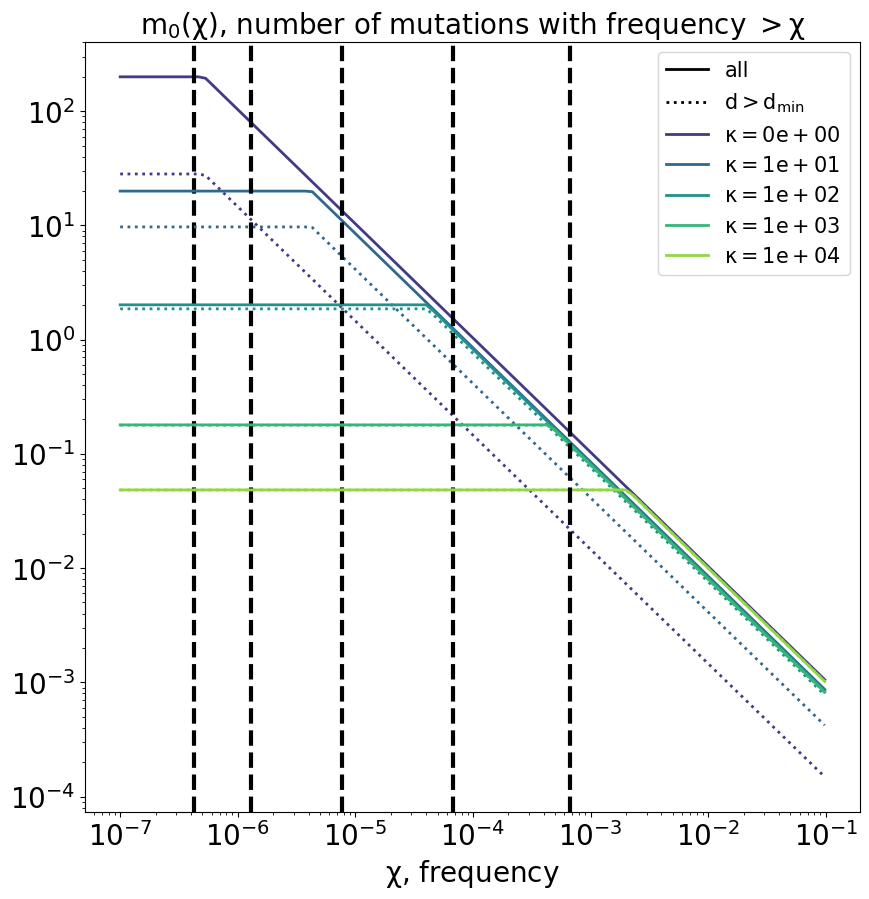

In [17]:
zinf = z[-1]

fig,ax= plt.subplots(1,1,figsize=(10,10))


chi_max = 1/(N*y[0])
chi_s = np.logspace(np.log10(1/N),np.log10(chi_max*.98),100)

for kappa in kappa_s:
    ts, (S,I) = integrate_trajectory(R0, kappa, N, 10)
    x,y = S/N, I/N
    z = 1-x-y
    tp = ts[np.argmax(y)]

    y_restricted = y[ts<tp]
    ts_restricted = ts[ts<tp]
    zinf = z[-1]

    indtilde = np.argmin(np.abs(muN*z*np.power((R0-1)/(R0*zinf),1/delta) -1))
    ttilde = ts[indtilde]

    # chi_min_tilde = 1/(N*y_restricted[indtilde])
    # law_ttilde = muN*z[indtilde]* (chi_min_tilde/chi_s * (chi_max-chi_min_tilde)/(chi_max-chi_min_tilde) * (chi_s>chi_min_tilde) + (chi_s<chi_min_tilde)*1)
    # ax.plot(chi_s, law_ttilde, color=colors_kappa[kappa], lw= 2)

    # conditioned_law_ttilde = law_ttilde * np.power((R0-1)/(R0*zinf),1/delta)
    # ax.plot(chi_s, conditioned_law_ttilde, color=colors_kappa[kappa], lw= 2,ls=':')
    # ax.axvline(1/(N*np.max(y)), color=colors_kappa[kappa], linestyle='--')

    ind_z_exp = np.argmin(np.abs(np.log(z*(2* R0* kappa)))) if kappa>0 else np.argmin(np.abs(z-(2* R0)**-1))
    chi_min_exp = 1/(N*y_restricted[ind_z_exp])
    law_exp = muN*z[ind_z_exp]* (chi_min_exp/chi_s * (chi_max-chi_min_exp)/(chi_max-chi_min_exp) * (chi_s>chi_min_exp) + (chi_s<chi_min_exp)*1)

    print(chi_min_exp)
    ax.plot(chi_s, law_exp, color=colors_kappa[kappa], lw= 2)

    conditioned_law_exp = law_exp * np.power((R0-1)/(R0*zinf),1/delta)
    ax.plot(chi_s, conditioned_law_exp, color=colors_kappa[kappa], lw= 2,ls=':')
    ax.axvline(1/(N*np.max(y)), color='black', linestyle='--')



ax.set_xscale('log')
ax.set_yscale('log')
handles = [Line2D([0], [0], color='black', lw=2, label=r'all'),
           Line2D([0], [0], color='black', lw=2, linestyle=':',
                   label=r'$d>d_\mathrm{min}$')]\
                      + [ Line2D([0], [0], color=colors_kappa[kappa], lw=2, label=fr'$\kappa={kappa:.0e}$') for kappa in kappa_s]
ax.legend(handles=handles, loc='upper right', fontsize=15)

ax.set_title(r'$m_0(\chi)$, number of mutations with frequency $>\chi$',fontsize=20)
ax.set_xlabel(r'$\chi$, frequency',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)

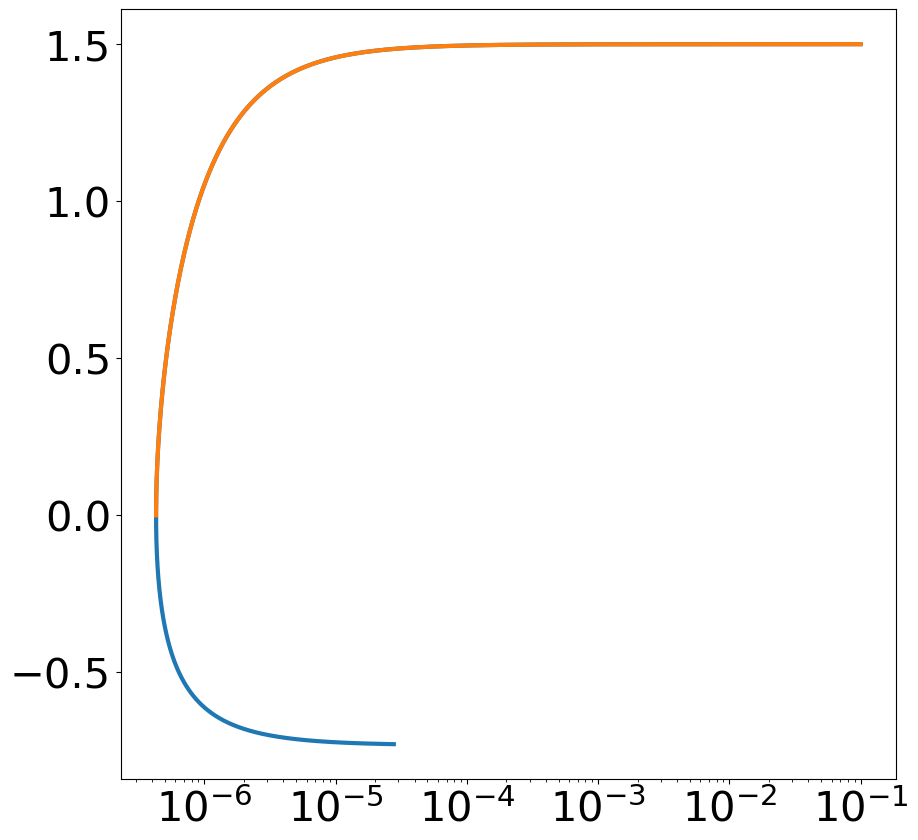

In [11]:
kappa = 0
ts, (S,I) = integrate_trajectory(R0, kappa, N, 10)
x,y = S/N, I/N
z = 1-x-y

chi = 1/(N*y)
f0 = R0/(1+kappa*y)*(x) -1
fig,ax= plt.subplots(1,1,figsize=(10,10))
ax.plot(1/(N*y), f0)
ax.set_xscale('log')

chi_restricted = chi[f0>0]
f0_restricted = f0[f0>0]
ax.plot(chi_restricted, f0_restricted)

f0_of_chi = spi.interp1d(chi_restricted, f0_restricted, fill_value='extrapolate')


In [12]:
from scipy.integrate import cumtrapz

/var/folders/r0/2r01pw2j68bcxs_rw3gqyh880000gn/T/ipykernel_1931/1520885086.py:27: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  cum_freq_spectrum = cumtrapz(freq_spectrum, chi_s, initial=0)


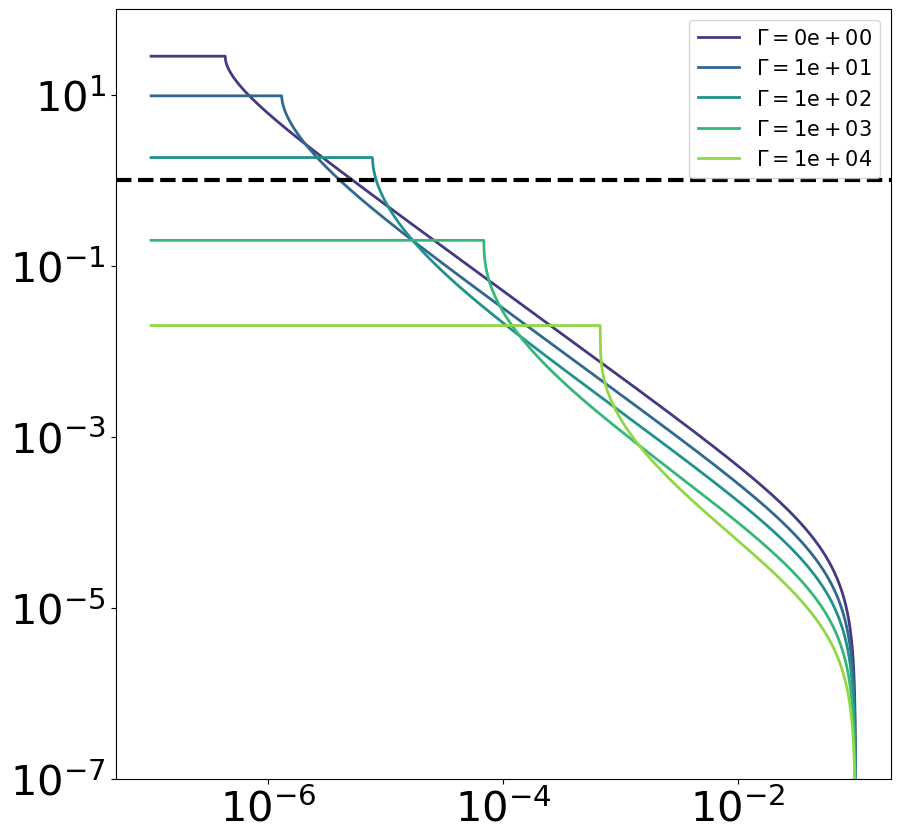

In [59]:
fig,ax = plt.subplots(1,1,figsize=(10,10),sharey=True)
for kappa in kappa_s:
    ts, (S,I) = integrate_trajectory(R0, kappa, N, 10,Nsteps = int(1e7))
    x,y = S/N, I/N
    z = 1-x-y
    tp = ts[np.argmax(y)]
    y_restricted = y[ts<tp]
    ts_restricted = ts[ts<tp]

    chi = 1/(N*y)
    f0 = R0/(1+kappa*y)*(x) -1
    
    yp = np.max(y)
    ind_z_exp = np.argmin(np.abs(np.log(z*(2* R0* kappa)))) if kappa>0 else np.argmin(np.abs(z-(2* R0)**-1))
    zinf= z[-1]
    chi_restricted = chi[f0>0]
    f0_restricted = f0[f0>0]
    
    f0_of_chi = spi.interp1d(chi_restricted, f0_restricted, fill_value='extrapolate')
    # f0_of_chi_true = lambda chi: f0_of_chi(chi) if chi>1/(N*y[0]) else 0
    # ax.plot(chi_restricted, f0_restricted)

    chi_s = np.logspace(np.log10(1/N),np.log10(1/(N*y[0])),10000)
    freq_spectrum = N/(chi_s**(2)*f0_of_chi(chi_s))*(chi_s>1/(N*yp) )
    freq_spectrum/= np.trapz(freq_spectrum, chi_s)

    cum_freq_spectrum = cumtrapz(freq_spectrum, chi_s, initial=0)

    
    ax.plot(chi_s, muN*z[ind_z_exp]*(1-cum_freq_spectrum), color=colors_kappa[kappa], lw= 2,alpha=0)
    ax.plot(chi_s, muN*z[ind_z_exp]*(1-cum_freq_spectrum)* np.power((R0-1)/(R0*zinf),1/delta) , color=colors_kappa[kappa], lw= 2,ls='-',label = fr'$\Gamma={kappa:.0e}$')
    # ind_z_exp = np.argmin(np.abs(np.log(z*(2* R0* kappa)))) if kappa>0 else np.argmin(np.abs(z-(2* R0)**-1))
    chi_min_exp = 1/(N*y_restricted[ind_z_exp])
    law_exp = muN*z[ind_z_exp]* (chi_min_exp/chi_s * (chi_max-chi_min_exp)/(chi_max-chi_min_exp) * (chi_s>chi_min_exp) + (chi_s<chi_min_exp)*1)

ax.legend(fontsize=15)
ax.axhline(1, color='black', linestyle='--')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(bottom=1/N,top=100)  

plt.savefig(output_folder+'m0_chi.svg',bbox_inches='tight')

/var/folders/r0/2r01pw2j68bcxs_rw3gqyh880000gn/T/ipykernel_1931/1148696059.py:27: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  cum_freq_spectrum = cumtrapz(freq_spectrum, chi_s, initial=0)


5.16876052410664e-07
4.245811236460956e-06
4.1090745094819395e-05
0.00040856688109685186
0.003979232399901378


(1e-07, 1530.9746553161028)

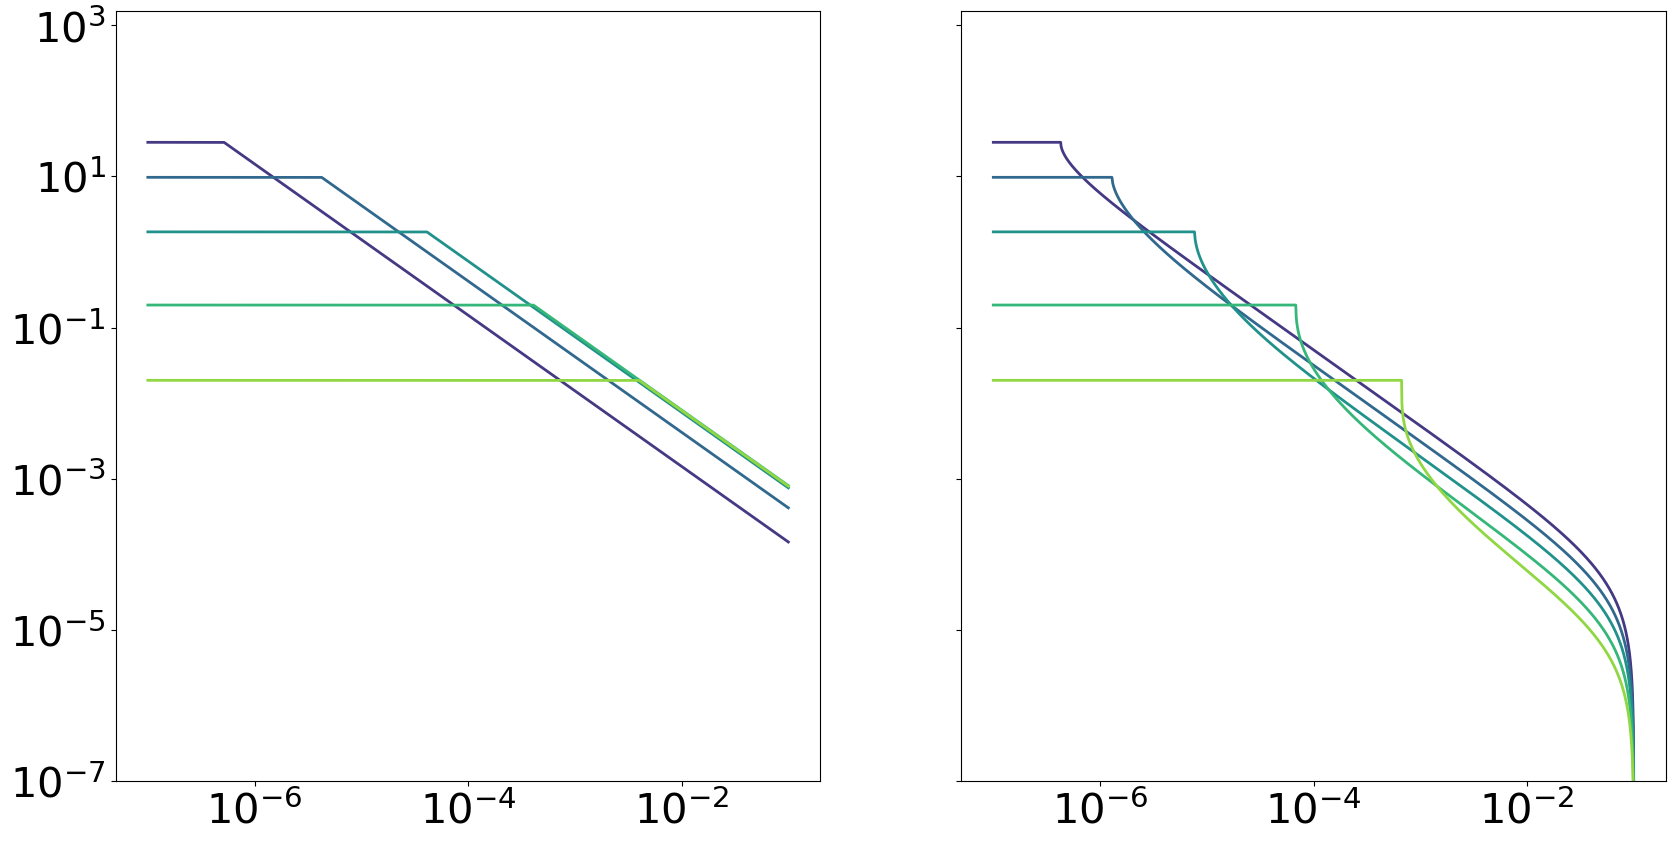

In [53]:
fig,ax = plt.subplots(1,2,figsize=(20,10),sharey=True)
for kappa in kappa_s:
    ts, (S,I) = integrate_trajectory(R0, kappa, N, 10,Nsteps = int(1e7))
    x,y = S/N, I/N
    z = 1-x-y
    tp = ts[np.argmax(y)]
    y_restricted = y[ts<tp]
    ts_restricted = ts[ts<tp]

    chi = 1/(N*y)
    f0 = R0/(1+kappa*y)*(x) -1
    
    yp = np.max(y)
    ind_z_exp = np.argmin(np.abs(np.log(z*(2* R0* kappa)))) if kappa>0 else np.argmin(np.abs(z-(2* R0)**-1))
    zinf= z[-1]
    chi_restricted = chi[f0>0]
    f0_restricted = f0[f0>0]
    
    f0_of_chi = spi.interp1d(chi_restricted, f0_restricted, fill_value='extrapolate')
    # f0_of_chi_true = lambda chi: f0_of_chi(chi) if chi>1/(N*y[0]) else 0
    # ax[1].plot(chi_restricted, f0_restricted)

    chi_s = np.logspace(np.log10(1/N),np.log10(1/(N*y[0])),10000)
    freq_spectrum = N/(chi_s**(2)*f0_of_chi(chi_s))*(chi_s>1/(N*yp) )
    freq_spectrum/= np.trapz(freq_spectrum, chi_s)

    cum_freq_spectrum = cumtrapz(freq_spectrum, chi_s, initial=0)

    
    ax[1].plot(chi_s, muN*z[ind_z_exp]*(1-cum_freq_spectrum), color=colors_kappa[kappa], lw= 2,alpha=0)
    ax[1].plot(chi_s, muN*z[ind_z_exp]*(1-cum_freq_spectrum)* np.power((R0-1)/(R0*zinf),1/delta) , color=colors_kappa[kappa], lw= 2,ls='-')
    # ind_z_exp = np.argmin(np.abs(np.log(z*(2* R0* kappa)))) if kappa>0 else np.argmin(np.abs(z-(2* R0)**-1))
    chi_min_exp = 1/(N*y_restricted[ind_z_exp])
    law_exp = muN*z[ind_z_exp]* (chi_min_exp/chi_s * (chi_max-chi_min_exp)/(chi_max-chi_min_exp) * (chi_s>chi_min_exp) + (chi_s<chi_min_exp)*1)

    print(chi_min_exp)
    ax[0].plot(chi_s, law_exp, color=colors_kappa[kappa], lw= 2,alpha=0)

    conditioned_law_exp = law_exp * np.power((R0-1)/(R0*zinf),1/delta)
    ax[0].plot(chi_s, conditioned_law_exp, color=colors_kappa[kappa], lw= 2,ls='-')
    # ax[0].axvline(1/(N*np.max(y)), color='black', linestyle='--')



ax[0].set_xscale('log')
ax[0].set_yscale('log')
    

ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_ylim(bottom=1/N)  

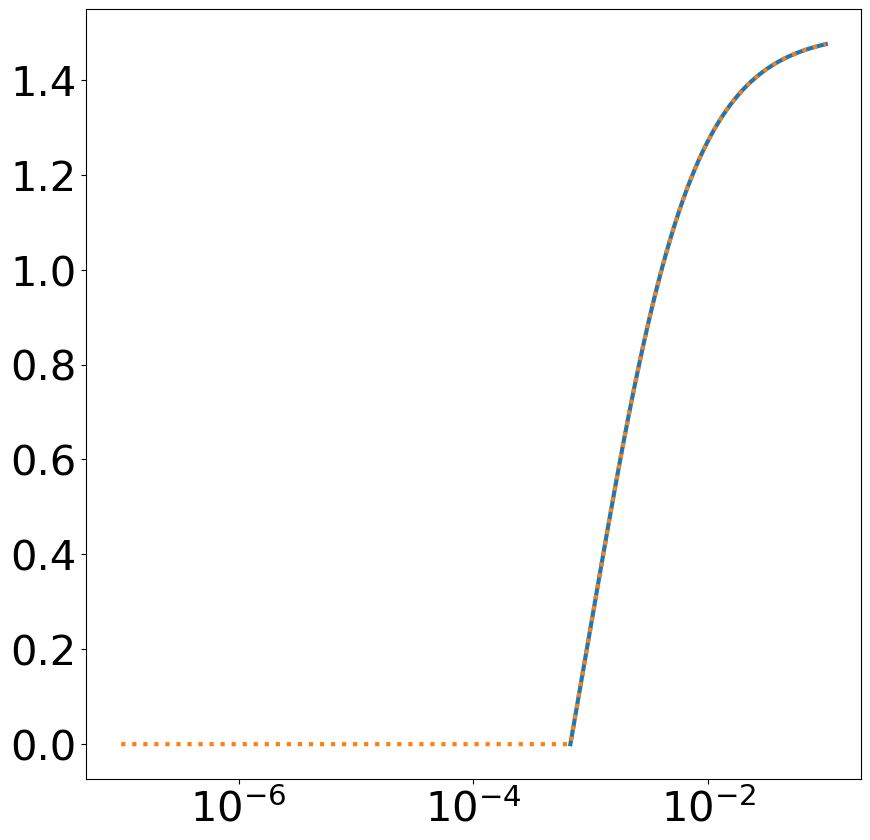

In [47]:
fig,ax= plt.subplots(1,1,figsize=(10,10))

ax.plot(chi_restricted, f0_restricted)
ylim = ax.get_ylim()

ax.plot(chi_s, f0_of_chi(chi_s)*(chi_s>1/(N*yp)),ls=':')
# ax.plot(chi_s, f0_true,ls=':')
ax.set_ylim(ylim)
ax.set_xscale('log')

In [35]:
f0_true

array([0, 0, 0, ..., 0, 0, 0])